<a href="https://colab.research.google.com/github/AchmadRaihan/MachineLearningCourses/blob/main/Final%20Exam/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function
from torchvision import datasets, transforms

# **Data Sets dan Data Loader**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset MNIST
train_loader = torch.utils.data.DataLoader(                                     
    datasets.MNIST(root='.', train=True, download=True,                 
                   transform=transforms.Compose([                       
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=120, shuffle=True, num_workers=4)

# Test dataset MNIST
test_loader = torch.utils.data.DataLoader(                                 
    datasets.MNIST(root='.', train=False,                                     
                  transform=transforms.Compose([                              
                  transforms.ToTensor(),
                  transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=100, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# **Build the Neural Network**

The model to perform system is Spasial Transformer Networks (STN). Spatial transformer networks (STN) allow a neural network to learn how to perform spatial transformations on the input image in order to enhance the geometric invariance of the model.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


# Connect the neural network to device (CPU atau GPU)
model = Net().to(device)                                                        

## Build the Hyperparameter

In [4]:
class EMA:
    def __init__(self, model, decay):
        self.decay = decay
        self.shadow = {}
        self.original = {}

        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def __call__(self, model, num_updates):
        decay = min(self.decay, (1.0 + num_updates) / (10.0 + num_updates))
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - decay) * param.data + decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def assign(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.original[name] = param.data.clone()
                param.data = self.shadow[name]

    def resume(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                param.data = self.original[name]

In [5]:
# hyperparameter selection ----------------------------------------------------#
ema = EMA(model, decay=0.999)
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

# **Train**

In [6]:
# global variables ------------------------------------------------------------#
g_step = 0
max_correct = 0

In [7]:
# training and evaluation loop ------------------------------------------------#
for epoch in range(5):
#--------------------------------------------------------------------------#
# train process                                                            #
#--------------------------------------------------------------------------#
    model.train()
    train_loss = 0
    train_corr = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_pred = output.argmax(dim=1, keepdim=True)
        train_corr += train_pred.eq(target.view_as(train_pred)).sum().item()
        train_loss += F.nll_loss(output, target, reduction='sum').item()
        loss.backward()
        optimizer.step()
        g_step += 1
        ema(model, g_step)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:05d}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * train_corr / len(train_loader.dataset)

#--------------------------------------------------------------------------#
# test process                                                             #
#--------------------------------------------------------------------------#
    model.eval()
    ema.assign(model)
    test_loss = 0
    correct = 0
    total_pred = np.zeros(0)
    total_target = np.zeros(0)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            total_pred = np.append(total_pred, pred.cpu().numpy())
            total_target = np.append(total_target, target.cpu().numpy())
            correct += pred.eq(target.view_as(pred)).sum().item()
        if(max_correct < correct):
            torch.save(model.state_dict(), "model.pth")
            max_correct = correct
            print("Best accuracy! correct images: %5d"%correct)
    ema.resume(model)

#--------------------------------------------------------------------------#
# output                                                                   #
#--------------------------------------------------------------------------#
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / len(test_loader.dataset)
    best_test_accuracy = 100 * max_correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%) (best: {:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy, best_test_accuracy))

#--------------------------------------------------------------------------#
# update learning rate scheduler                                           #
#--------------------------------------------------------------------------#
    lr_scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

Train Epoch: 0 [00000/60000 (0%)]	Loss: 2.312541
Train Epoch: 0 [12000/60000 (20%)]	Loss: 0.516981
Train Epoch: 0 [24000/60000 (40%)]	Loss: 0.346729
Train Epoch: 0 [36000/60000 (60%)]	Loss: 0.281179
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.165787
Best accuracy! correct images:  9770

Test set: Average loss: 0.0723, Accuracy: 9770/10000 (97.70%) (best: 97.70%)

Train Epoch: 1 [00000/60000 (0%)]	Loss: 0.170297
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.107338
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.084110
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.190122
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.232117
Best accuracy! correct images:  9832

Test set: Average loss: 0.0502, Accuracy: 9832/10000 (98.32%) (best: 98.32%)

Train Epoch: 2 [00000/60000 (0%)]	Loss: 0.282331
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.182798
Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.104766
Train Epoch: 2 [36000/60000 (60%)]	Loss: 0.150800
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.272350
Best accuracy! correc

# **Visualisasi**

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Feature batch shape: torch.Size([120, 1, 28, 28])
Labels batch shape: torch.Size([120])


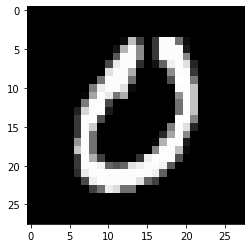

Label: 0


In [8]:
# Display image and label with train_loader in data sets
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

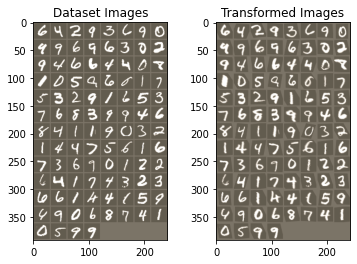

In [9]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()